#### Imports & Downloads

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score

from src.functions.vectorize_functions import vectorize_tfidf, vectorize_glove, vectorize_w2v

### Model Preparation

#### Functions

In [2]:
def print_target_distribution(df, colname):
    positive = np.count_nonzero(df[colname] == 1)
    negative = np.count_nonzero(df[colname] == 0)
    print("- Positive:", positive)
    print("- Negative:", negative)
    print("- Verhältnis:", negative / positive)

In [3]:
evaluation = pd.DataFrame(
    columns=["model", "tuning", "vec_variant", "train_acc", "train_prec", "train_rec", "train_f1", "test_acc",
             "test_prec",
             "test_rec", "test_f1"])

In [4]:
def add_to_eval_df(model, model_name, tuning, vec_variant, x_data_train, y_data_train, x_data_test, y_data_test):
    train_acc = model.score(x_data_train, y_data_train)
    train_precision = precision_score(y_data_train, model.predict(x_data_train))
    train_recall = recall_score(y_data_train, model.predict(x_data_train))
    train_f1 = f1_score(y_data_train, model.predict(x_data_train))

    test_acc = model.score(x_data_test, y_data_test)
    test_precision = precision_score(y_data_test, model.predict(x_data_test))
    test_recall = recall_score(y_data_test, model.predict(x_data_test))
    test_f1 = f1_score(y_data_test, model.predict(x_data_test))

    evaluation.loc[len(evaluation.index)] = [model_name, tuning, vec_variant, train_acc, train_precision, train_recall,
                                             train_f1,
                                             test_acc, test_precision, test_recall, test_f1]

In [5]:
def evaluate_model(model, x_test, y_test):
    pred = model.predict(x_test)
    accscore = metrics.accuracy_score(pred, y_test)

    print(f'model accuracy for classification is =', str('{:04.2f}'.format(accscore * 100)) + '%')
    print('------------------------------------------------')
    print('Confusion Matrix:')
    print(pd.DataFrame(confusion_matrix(y_test, pred)))
    print('------------------------------------------------')
    print('Classification Report:')
    print(classification_report(y_test, pred))

    probs = model.predict_proba(x_test)
    preds = probs[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


#### Data Import

In [6]:
df_train_cleaned = pd.read_csv("..\\..\\..\\data\\new_datasets\\train_cleaned.csv")

In [7]:
print_target_distribution(df_train_cleaned, 'label')

- Positive: 13103
- Negative: 48155
- Verhältnis: 3.6751125696405404


In [8]:
df_train_cleaned = df_train_cleaned[df_train_cleaned.tweet_cleaned.notna()]
df_train_cleaned.isna().sum()

Unnamed: 0           0
tweet                0
label                0
tweet_cleaned        0
user_handle          0
hashtags             0
emojis           58161
dtype: int64

#### Vectorize - Word2Vec

In [9]:
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = vectorize_w2v(df=df_train_cleaned,
                                                                 text_column="tweet_cleaned",
                                                                 label_column="label")

#### Vectorize - TF-IDF

In [10]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = vectorize_tfidf(df=df_train_cleaned,
                                                               text_column="tweet_cleaned",
                                                               label_column="label")

#### Vectorize - Glove

In [11]:
X_train_gl, X_test_gl, y_train_gl, y_test_gl = vectorize_glove(df=df_train_cleaned,
                                                               text_column="tweet_cleaned",
                                                               label_column="label")

### Training Functions

In [12]:
def cross_validate_model(model, x_data, y_data, cv=10, scoring='f1'):
    cv = cross_val_score(model, x_data, y_data, cv=cv, scoring=scoring, verbose=10)
    print(f" MEAN: {np.mean(cv)}")

    return cv

#### 1.1 Bagging

##### 1.1.1 RandomForest

In [13]:
def train_randomforest(x_data, y_data):
    model = RandomForestClassifier(n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [14]:
def train_randomforest_tuned_randsearch(x_data, y_data):
    model = RandomForestClassifier(n_jobs=-1, max_depth=9, max_features=None, max_leaf_nodes=13)
    model.fit(x_data, y_data)

    return model

In [15]:
def train_randomforest_tuned_optuna(x_data, y_data):
    model = RandomForestClassifier(n_jobs=-1, n_estimators=450, max_depth=55, min_samples_split=4, min_samples_leaf=1)
    model.fit(x_data, y_data)

    return model

##### 1.1.2 BalancedRandomForest untuned

In [16]:
def train_balancedrandomforest(x_data, y_data):
    model = BalancedRandomForestClassifier(n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [17]:
# def train_balancedrandomforest_tuned(x_data, y_data):
#     model = BalancedRandomForestClassifier(n_jobs=-1, max_depth=9, max_features=None, max_leaf_nodes=13)
#     model.fit(x_data, y_data)
#
#     return model

#### 1.2 Boosting

##### 1.2.1 XGBClassifier

In [18]:
def train_xgboost(x_data, y_data):
    model = XGBClassifier(n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [19]:
def train_xgboost_tuned_gridsearch(x_data, y_data):
    model = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=11, subsample=0.7, reg_alpha=0.01)
    model.fit(x_data, y_data)

    return model

In [20]:
def train_xgboost_tuned_randsearch(x_data, y_data):
    model = XGBClassifier(n_jobs=-1, subsample=0.5, reg_alpha=1, n_estimators=150, min_child_weight=1,
                          max_depth=7, learning_rate=0.1, gamma=0.4)
    model.fit(x_data, y_data)

    return model

In [21]:
def train_xgboost_tuned_optuna(x_data, y_data):
    model = XGBClassifier(n_jobs=-1, boost='gblinear', subsample=0.4736419905302216,
                          colsample_bytree=0.6711055768358083, alpha=8.528933855762793e-06)
    model.fit(x_data, y_data)

    return model

##### 1.2.1 CatBoostClassifier

In [22]:
def train_catboost(x_data, y_data):
    model = CatBoostClassifier(iterations=100,
                               depth=5,
                               learning_rate=0.1,
                               loss_function='Logloss',
                               verbose=True)
    model.fit(x_data, y_data)

    return model

##### 1.2.1 LGBMClassifier

In [23]:
def train_lightgbm(x_data, y_data):
    model = LGBMClassifier()
    model.fit(x_data, y_data)

    return model

#### 1.3 Stacking

##### 1.3.1 Stacking: RandomForest + LinearSVC

In [24]:
def train_stacking_rf_svm(x_data, y_data):
    base_models = [
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', LinearSVC(random_state=42))
    ]
    model = StackingClassifier(estimators=base_models, n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [25]:
def train_svc(x_data, y_data):
    model = LinearSVC()
    model.fit(x_data, y_data)

    return model

### Model Training

#### W2V

model accuracy for classification is = 80.87%
------------------------------------------------
Confusion Matrix:
       0    1
0  14240  219
1   3296  623
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.98      0.89     14459
           1       0.74      0.16      0.26      3919

    accuracy                           0.81     18378
   macro avg       0.78      0.57      0.58     18378
weighted avg       0.80      0.81      0.76     18378



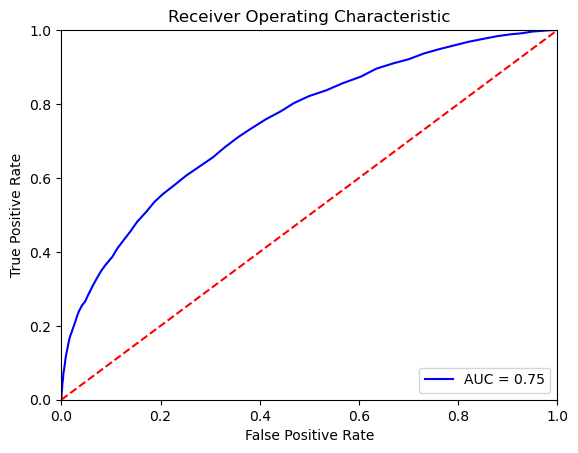

In [26]:
rf_untuned_w2v = train_randomforest(X_train_w2v, y_train_w2v)
evaluate_model(rf_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(rf_untuned_w2v, "RandomForest", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 79.26%
------------------------------------------------
Confusion Matrix:
       0    1
0  14411   48
1   3764  155
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     14459
           1       0.76      0.04      0.08      3919

    accuracy                           0.79     18378
   macro avg       0.78      0.52      0.48     18378
weighted avg       0.79      0.79      0.71     18378



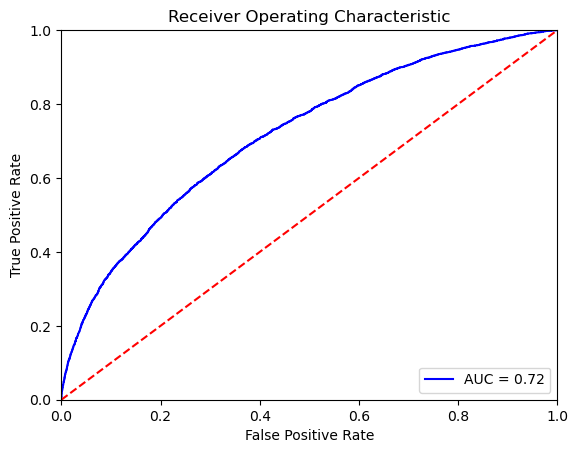

In [27]:
rf_rand_w2v = train_randomforest_tuned_randsearch(X_train_w2v, y_train_w2v)
evaluate_model(rf_rand_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(rf_rand_w2v, "RandomForest", "randsearch", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 81.00%
------------------------------------------------
Confusion Matrix:
       0    1
0  14267  192
1   3300  619
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89     14459
           1       0.76      0.16      0.26      3919

    accuracy                           0.81     18378
   macro avg       0.79      0.57      0.58     18378
weighted avg       0.80      0.81      0.76     18378



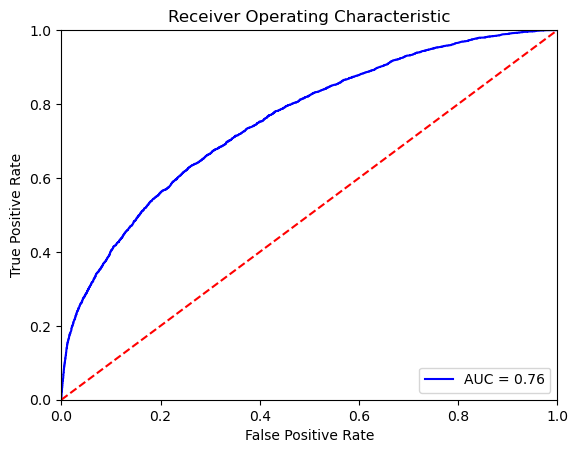

In [28]:
rf_optuna_w2v = train_randomforest_tuned_optuna(X_train_w2v, y_train_w2v)
evaluate_model(rf_optuna_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(rf_optuna_w2v, "RandomForest", "optuna", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

model accuracy for classification is = 71.78%
------------------------------------------------
Confusion Matrix:
       0     1
0  10488  3971
1   1215  2704
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.73      0.80     14459
           1       0.41      0.69      0.51      3919

    accuracy                           0.72     18378
   macro avg       0.65      0.71      0.66     18378
weighted avg       0.79      0.72      0.74     18378



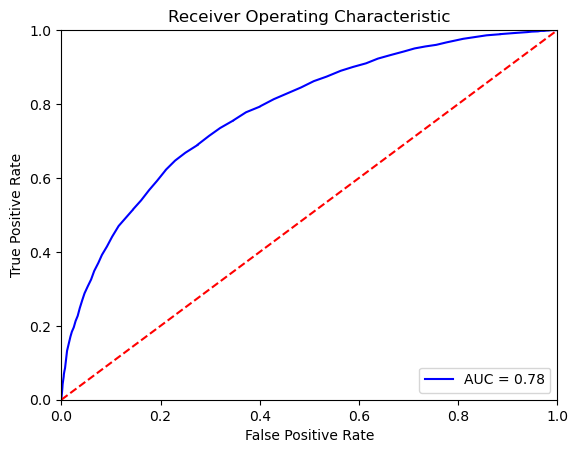

In [29]:
brf_untuned_w2v = train_balancedrandomforest(X_train_w2v, y_train_w2v)
evaluate_model(brf_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(brf_untuned_w2v, "BalancedRandomForest", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v,
               y_test_w2v)

model accuracy for classification is = 81.09%
------------------------------------------------
Confusion Matrix:
       0     1
0  13603   856
1   2619  1300
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89     14459
           1       0.60      0.33      0.43      3919

    accuracy                           0.81     18378
   macro avg       0.72      0.64      0.66     18378
weighted avg       0.79      0.81      0.79     18378



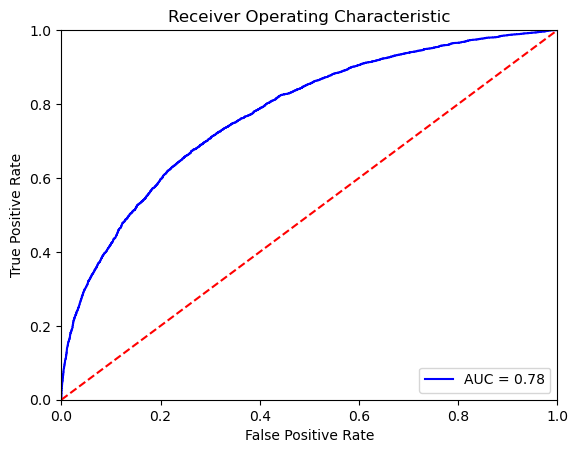

In [30]:
xgb_untuned_w2v = train_xgboost(X_train_w2v, y_train_w2v)
evaluate_model(xgb_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_untuned_w2v, "XGBoost", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 81.91%
------------------------------------------------
Confusion Matrix:
       0     1
0  13906   553
1   2772  1147
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89     14459
           1       0.67      0.29      0.41      3919

    accuracy                           0.82     18378
   macro avg       0.75      0.63      0.65     18378
weighted avg       0.80      0.82      0.79     18378



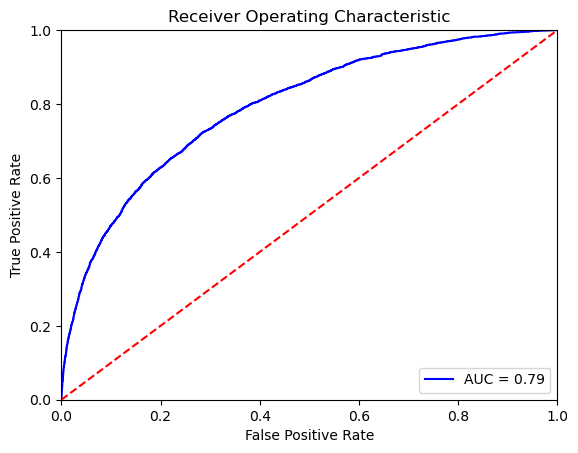

In [31]:
xgb_grid_w2v = train_xgboost_tuned_gridsearch(X_train_w2v, y_train_w2v)
evaluate_model(xgb_grid_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_grid_w2v, "XGBoost", "gridsearch", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 81.85%
------------------------------------------------
Confusion Matrix:
       0     1
0  13789   670
1   2665  1254
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89     14459
           1       0.65      0.32      0.43      3919

    accuracy                           0.82     18378
   macro avg       0.74      0.64      0.66     18378
weighted avg       0.80      0.82      0.79     18378



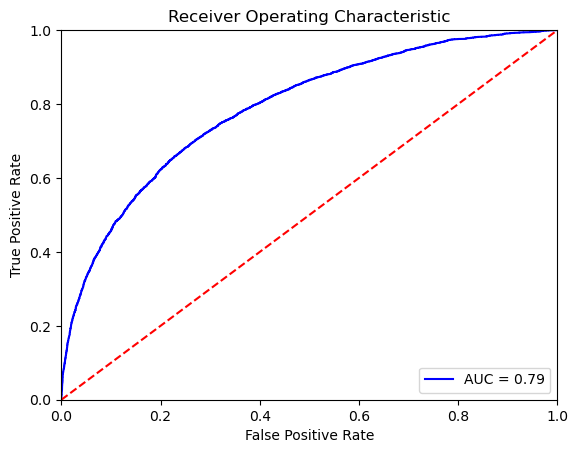

In [32]:
xgb_rand_w2v = train_xgboost_tuned_randsearch(X_train_w2v, y_train_w2v)
evaluate_model(xgb_rand_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_rand_w2v, "XGBoost", "randsearch", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

C:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [16:26:28] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "boost" } are not used.

  warnings.warn(smsg, UserWarning)


model accuracy for classification is = 79.83%
------------------------------------------------
Confusion Matrix:
       0     1
0  13299  1160
1   2546  1373
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88     14459
           1       0.54      0.35      0.43      3919

    accuracy                           0.80     18378
   macro avg       0.69      0.64      0.65     18378
weighted avg       0.78      0.80      0.78     18378



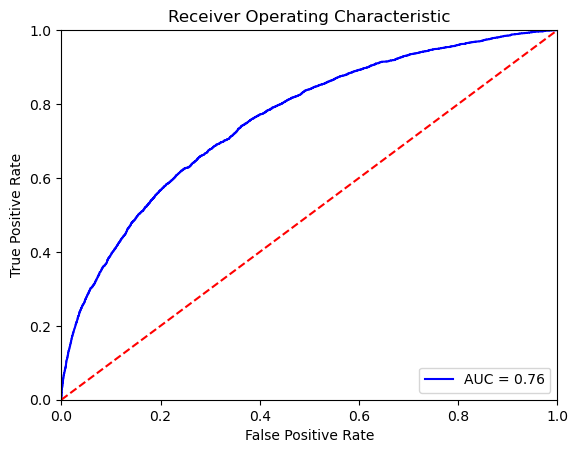

In [33]:
xgb_optuna_w2v = train_xgboost_tuned_optuna(X_train_w2v, y_train_w2v)
evaluate_model(xgb_optuna_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_optuna_w2v, "XGBoost", "optuna", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

0:	learn: 0.6514008	total: 169ms	remaining: 16.7s
1:	learn: 0.6181648	total: 205ms	remaining: 10.1s
2:	learn: 0.5914565	total: 240ms	remaining: 7.76s
3:	learn: 0.5712674	total: 277ms	remaining: 6.64s
4:	learn: 0.5537875	total: 313ms	remaining: 5.95s
5:	learn: 0.5383370	total: 350ms	remaining: 5.48s
6:	learn: 0.5265334	total: 383ms	remaining: 5.08s
7:	learn: 0.5170975	total: 417ms	remaining: 4.79s
8:	learn: 0.5086699	total: 454ms	remaining: 4.59s
9:	learn: 0.5009162	total: 490ms	remaining: 4.41s
10:	learn: 0.4953864	total: 524ms	remaining: 4.24s
11:	learn: 0.4898111	total: 561ms	remaining: 4.12s
12:	learn: 0.4852452	total: 597ms	remaining: 4s
13:	learn: 0.4810542	total: 633ms	remaining: 3.89s
14:	learn: 0.4781928	total: 673ms	remaining: 3.81s
15:	learn: 0.4751311	total: 710ms	remaining: 3.73s
16:	learn: 0.4720835	total: 744ms	remaining: 3.63s
17:	learn: 0.4697258	total: 781ms	remaining: 3.56s
18:	learn: 0.4676226	total: 817ms	remaining: 3.48s
19:	learn: 0.4656551	total: 851ms	remaining:

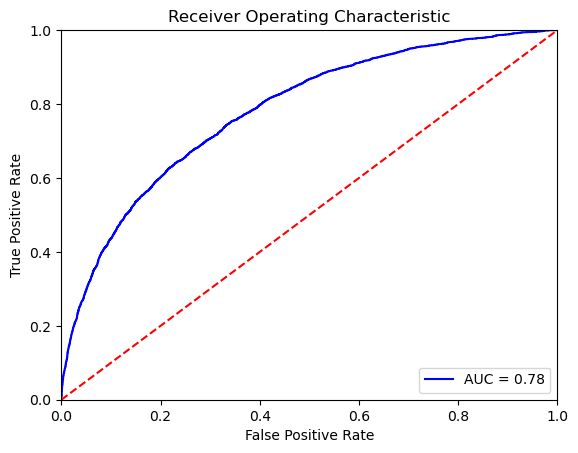

In [34]:
cat_untuned_w2v = train_catboost(X_train_w2v, y_train_w2v)
evaluate_model(cat_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(cat_untuned_w2v, "CatBoostClassifier", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v,
               y_test_w2v)

[LightGBM] [Info] Number of positive: 9184, number of negative: 33695
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 42879, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.214184 -> initscore=-1.299887
[LightGBM] [Info] Start training from score -1.299887
model accuracy for classification is = 81.60%
------------------------------------------------
Confusion Matrix:
       0     1
0  13894   565
1   2817  1102
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89     14459
           1       0.66      0.28      0.39      3919

    accuracy                           0.82     18378
   macro avg       0.75      0.62      0.64     18378
wei

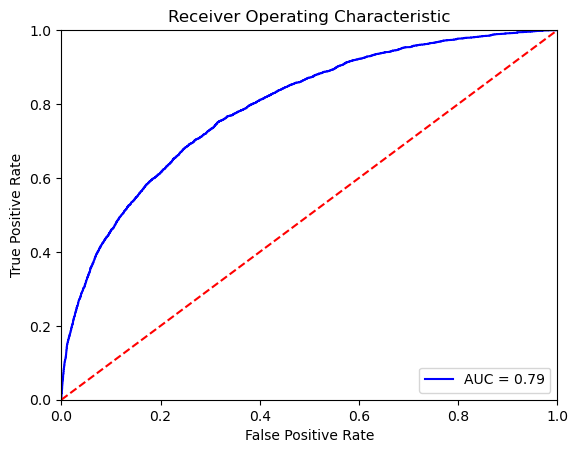

In [35]:
light_untuned_w2v = train_lightgbm(X_train_w2v, y_train_w2v)
evaluate_model(light_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(light_untuned_w2v, "LightGBM", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 81.11%
------------------------------------------------
Confusion Matrix:
       0    1
0  13923  536
1   2936  983
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89     14459
           1       0.65      0.25      0.36      3919

    accuracy                           0.81     18378
   macro avg       0.74      0.61      0.63     18378
weighted avg       0.79      0.81      0.78     18378



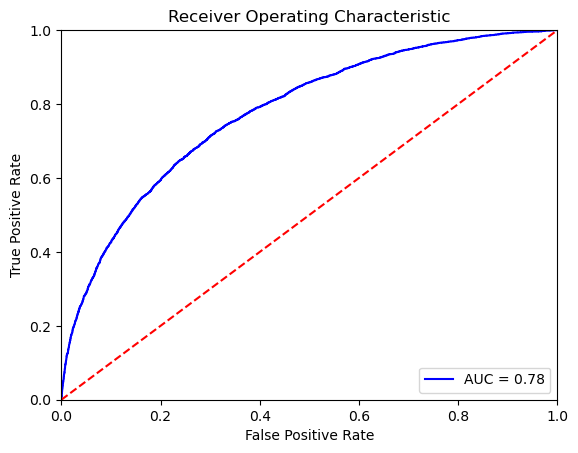

In [36]:
stack_untuned_w2v = train_stacking_rf_svm(X_train_w2v, y_train_w2v)
evaluate_model(stack_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(stack_untuned_w2v, "StackingClassifier-RF-SVC", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v,
               y_test_w2v)

In [37]:
svc_untuned_w2v = train_svc(X_train_w2v, y_train_w2v)
add_to_eval_df(svc_untuned_w2v, "SVC", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### TF-IDF

model accuracy for classification is = 82.16%
------------------------------------------------
Confusion Matrix:
       0     1
0  13980   479
1   2799  1120
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.97      0.90     14459
           1       0.70      0.29      0.41      3919

    accuracy                           0.82     18378
   macro avg       0.77      0.63      0.65     18378
weighted avg       0.80      0.82      0.79     18378



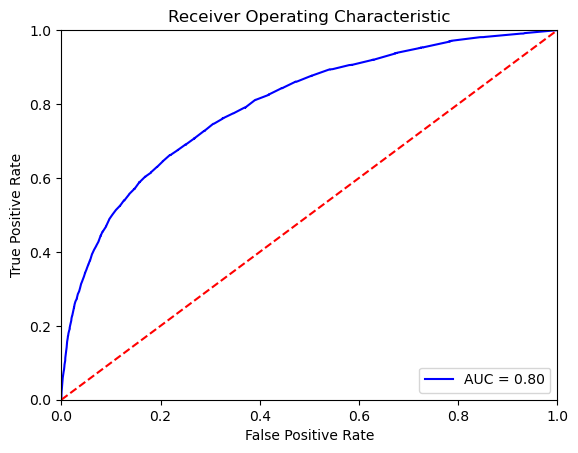

In [38]:
rf_untuned_tf = train_randomforest(X_train_tf, y_train_tf)
evaluate_model(rf_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(rf_untuned_tf, "RandomForest", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 81.59%
------------------------------------------------
Confusion Matrix:
       0     1
0  13970   489
1   2894  1025
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89     14459
           1       0.68      0.26      0.38      3919

    accuracy                           0.82     18378
   macro avg       0.75      0.61      0.63     18378
weighted avg       0.80      0.82      0.78     18378



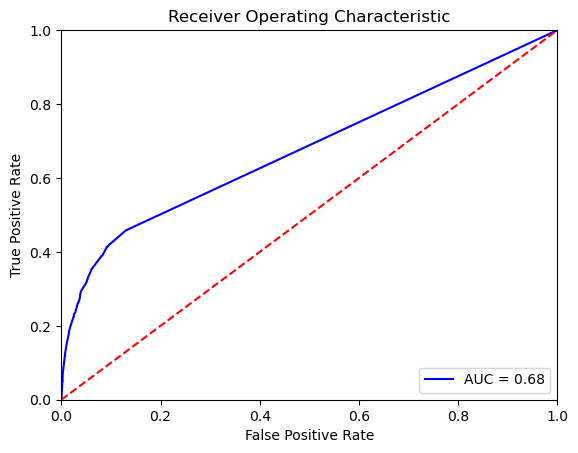

In [39]:
rf_rand_tf = train_randomforest_tuned_randsearch(X_train_tf, y_train_tf)
evaluate_model(rf_rand_tf, X_test_tf, y_test_tf)
add_to_eval_df(rf_rand_tf, "RandomForest", "randsearch", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 79.86%
------------------------------------------------
Confusion Matrix:
       0    1
0  14429   30
1   3671  248
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     14459
           1       0.89      0.06      0.12      3919

    accuracy                           0.80     18378
   macro avg       0.84      0.53      0.50     18378
weighted avg       0.82      0.80      0.72     18378



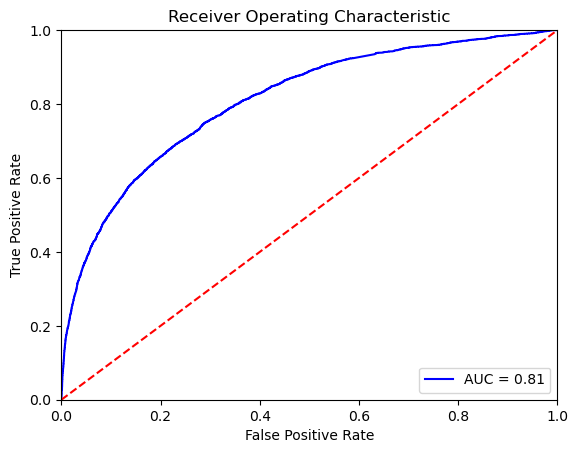

In [40]:
rf_optuna_tf = train_randomforest_tuned_optuna(X_train_tf, y_train_tf)
evaluate_model(rf_optuna_tf, X_test_tf, y_test_tf)
add_to_eval_df(rf_optuna_tf, "RandomForest", "optuna", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

model accuracy for classification is = 74.06%
------------------------------------------------
Confusion Matrix:
       0     1
0  10800  3659
1   1108  2811
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.75      0.82     14459
           1       0.43      0.72      0.54      3919

    accuracy                           0.74     18378
   macro avg       0.67      0.73      0.68     18378
weighted avg       0.81      0.74      0.76     18378



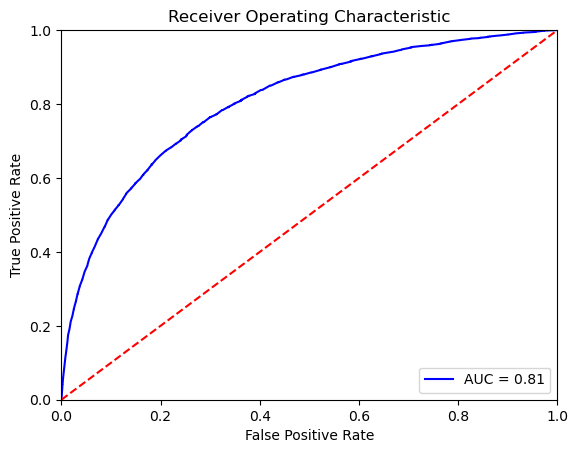

In [41]:
brf_untuned_tf = train_balancedrandomforest(X_train_tf, y_train_tf)
evaluate_model(brf_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(brf_untuned_tf, "BalancedRandomForest", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 82.77%
------------------------------------------------
Confusion Matrix:
       0     1
0  13998   461
1   2705  1214
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90     14459
           1       0.72      0.31      0.43      3919

    accuracy                           0.83     18378
   macro avg       0.78      0.64      0.67     18378
weighted avg       0.81      0.83      0.80     18378



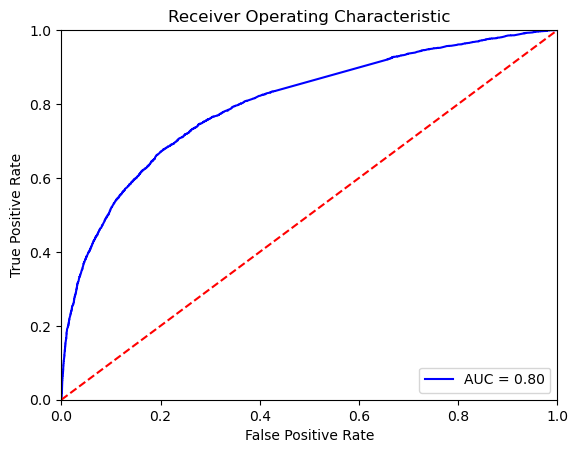

In [42]:
xgb_untuned_tf = train_xgboost(X_train_tf, y_train_tf)
evaluate_model(xgb_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_untuned_tf, "XGBoost", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 82.91%
------------------------------------------------
Confusion Matrix:
       0     1
0  13922   537
1   2604  1315
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90     14459
           1       0.71      0.34      0.46      3919

    accuracy                           0.83     18378
   macro avg       0.78      0.65      0.68     18378
weighted avg       0.81      0.83      0.80     18378



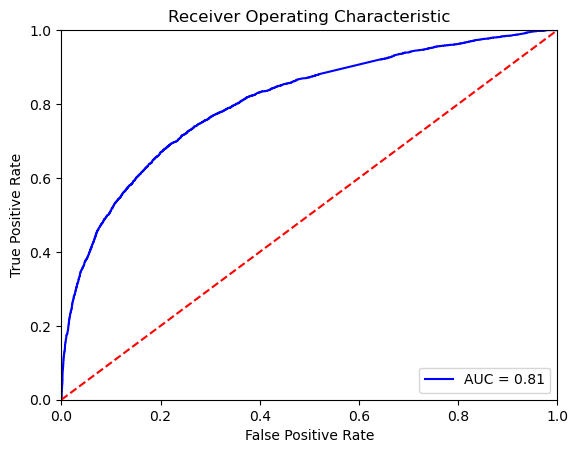

In [43]:
xgb_grid_tf = train_xgboost_tuned_gridsearch(X_train_tf, y_train_tf)
evaluate_model(xgb_grid_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_grid_tf, "XGBoost", "gridsearch", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 82.60%
------------------------------------------------
Confusion Matrix:
       0     1
0  14017   442
1   2756  1163
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90     14459
           1       0.72      0.30      0.42      3919

    accuracy                           0.83     18378
   macro avg       0.78      0.63      0.66     18378
weighted avg       0.81      0.83      0.80     18378



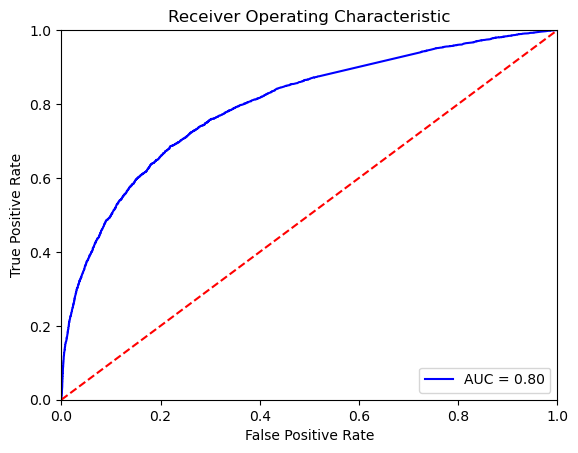

In [44]:
xgb_rand_tf = train_xgboost_tuned_randsearch(X_train_tf, y_train_tf)
evaluate_model(xgb_rand_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_rand_tf, "XGBoost", "randsearch", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

C:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [16:34:36] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "boost" } are not used.

  warnings.warn(smsg, UserWarning)


model accuracy for classification is = 82.60%
------------------------------------------------
Confusion Matrix:
       0     1
0  13875   584
1   2613  1306
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90     14459
           1       0.69      0.33      0.45      3919

    accuracy                           0.83     18378
   macro avg       0.77      0.65      0.67     18378
weighted avg       0.81      0.83      0.80     18378



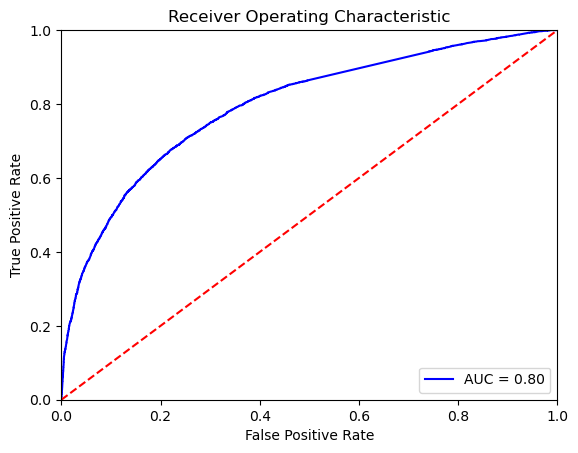

In [45]:
xgb_optuna_tf = train_xgboost_tuned_optuna(X_train_tf, y_train_tf)
evaluate_model(xgb_optuna_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_optuna_tf, "XGBoost", "optuna", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

0:	learn: 0.6529031	total: 88.4ms	remaining: 8.76s
1:	learn: 0.6211461	total: 173ms	remaining: 8.47s
2:	learn: 0.5950023	total: 255ms	remaining: 8.26s
3:	learn: 0.5727107	total: 342ms	remaining: 8.2s
4:	learn: 0.5572375	total: 429ms	remaining: 8.14s
5:	learn: 0.5432046	total: 515ms	remaining: 8.06s
6:	learn: 0.5307686	total: 600ms	remaining: 7.97s
7:	learn: 0.5214806	total: 691ms	remaining: 7.95s
8:	learn: 0.5132130	total: 779ms	remaining: 7.88s
9:	learn: 0.5059916	total: 867ms	remaining: 7.8s
10:	learn: 0.5001601	total: 957ms	remaining: 7.74s
11:	learn: 0.4952050	total: 1.04s	remaining: 7.63s
12:	learn: 0.4909213	total: 1.13s	remaining: 7.53s
13:	learn: 0.4875350	total: 1.21s	remaining: 7.45s
14:	learn: 0.4842737	total: 1.3s	remaining: 7.36s
15:	learn: 0.4815149	total: 1.38s	remaining: 7.26s
16:	learn: 0.4788510	total: 1.47s	remaining: 7.19s
17:	learn: 0.4765742	total: 1.56s	remaining: 7.1s
18:	learn: 0.4747001	total: 1.64s	remaining: 7s
19:	learn: 0.4729507	total: 1.73s	remaining: 6.

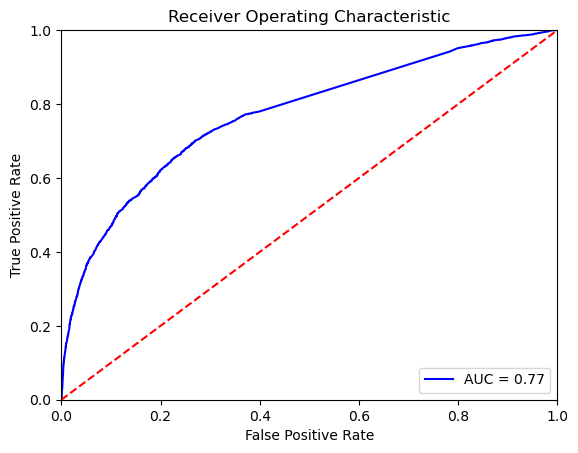

In [46]:
cat_untuned_tf = train_catboost(X_train_tf, y_train_tf)
evaluate_model(cat_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(cat_untuned_tf, "CatBoostClassifier", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

[LightGBM] [Info] Number of positive: 9184, number of negative: 33695
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102961
[LightGBM] [Info] Number of data points in the train set: 42879, number of used features: 2746
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.214184 -> initscore=-1.299887
[LightGBM] [Info] Start training from score -1.299887
model accuracy for classification is = 82.75%
------------------------------------------------
Confusion Matrix:
       0     1
0  13950   509
1   2661  1258
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90     14459
           1       0.71      0.32      0.44      3919

    accuracy                           0.83     18378
   macro avg       0.78      0.64      0.67     18378
w

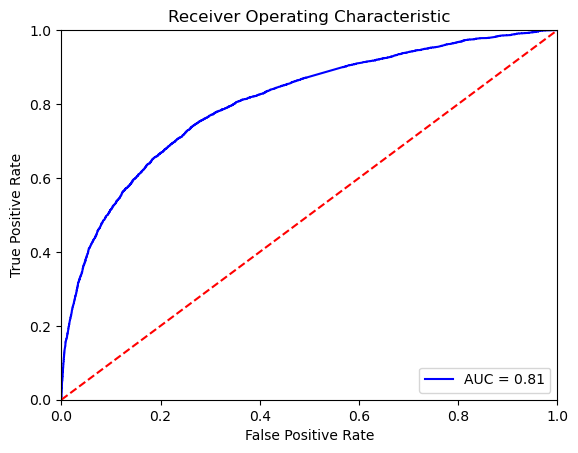

In [47]:
light_untuned_tf = train_lightgbm(X_train_tf, y_train_tf)
evaluate_model(light_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(light_untuned_tf, "LightGBM", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 82.81%
------------------------------------------------
Confusion Matrix:
       0     1
0  13847   612
1   2548  1371
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90     14459
           1       0.69      0.35      0.46      3919

    accuracy                           0.83     18378
   macro avg       0.77      0.65      0.68     18378
weighted avg       0.81      0.83      0.81     18378



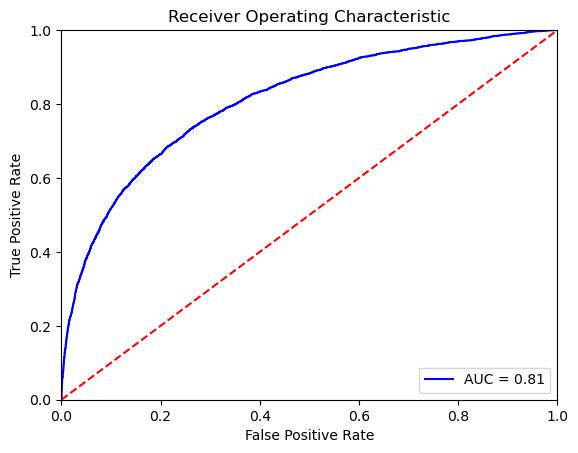

In [48]:
stack_untuned_tf = train_stacking_rf_svm(X_train_tf, y_train_tf)
evaluate_model(stack_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(stack_untuned_tf, "StackingClassifier-RF-SVC", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf,
               y_test_tf)

In [49]:
svc_untuned_tf = train_svc(X_train_tf, y_train_tf)
add_to_eval_df(svc_untuned_tf, "SVC", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

#### Glove100d

model accuracy for classification is = 79.95%
------------------------------------------------
Confusion Matrix:
       0    1
0  14259  200
1   3484  435
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.99      0.89     14459
           1       0.69      0.11      0.19      3919

    accuracy                           0.80     18378
   macro avg       0.74      0.55      0.54     18378
weighted avg       0.78      0.80      0.74     18378



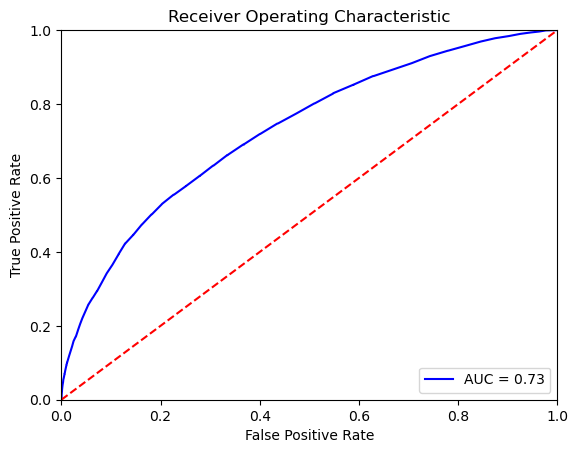

In [50]:
rf_untuned_gl = train_randomforest(X_train_gl, y_train_gl)
evaluate_model(rf_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(rf_untuned_gl, "RandomForest", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 78.96%
------------------------------------------------
Confusion Matrix:
       0    1
0  14391   68
1   3798  121
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     14459
           1       0.64      0.03      0.06      3919

    accuracy                           0.79     18378
   macro avg       0.72      0.51      0.47     18378
weighted avg       0.76      0.79      0.71     18378



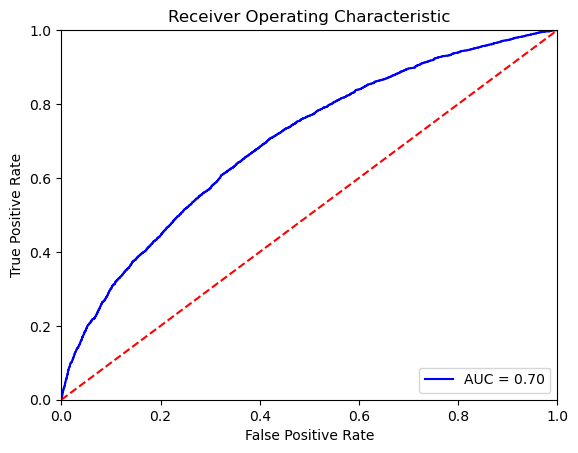

In [51]:
rf_rand_gl = train_randomforest_tuned_randsearch(X_train_gl, y_train_gl)
evaluate_model(rf_rand_gl, X_test_gl, y_test_gl)
add_to_eval_df(rf_rand_gl, "RandomForest", "randsearch", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 79.97%
------------------------------------------------
Confusion Matrix:
       0    1
0  14273  186
1   3496  423
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.99      0.89     14459
           1       0.69      0.11      0.19      3919

    accuracy                           0.80     18378
   macro avg       0.75      0.55      0.54     18378
weighted avg       0.78      0.80      0.74     18378



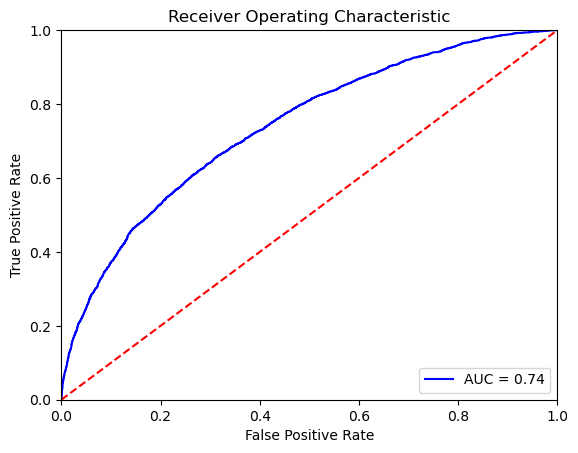

In [52]:
rf_optuna_gl = train_randomforest_tuned_optuna(X_train_gl, y_train_gl)
evaluate_model(rf_optuna_gl, X_test_gl, y_test_gl)
add_to_eval_df(rf_optuna_gl, "RandomForest", "optuna", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

model accuracy for classification is = 70.86%
------------------------------------------------
Confusion Matrix:
       0     1
0  10432  4027
1   1328  2591
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.72      0.80     14459
           1       0.39      0.66      0.49      3919

    accuracy                           0.71     18378
   macro avg       0.64      0.69      0.64     18378
weighted avg       0.78      0.71      0.73     18378



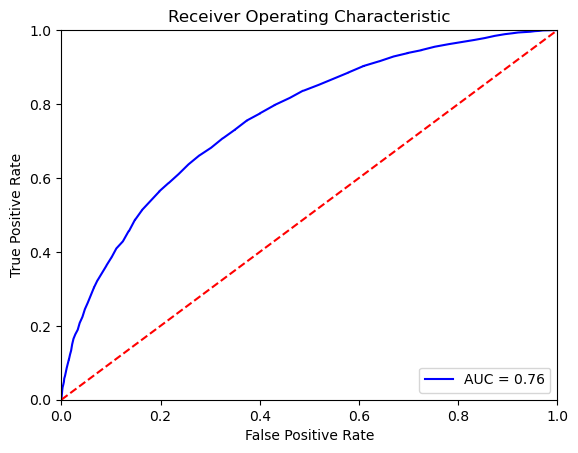

In [53]:
brf_untuned_gl = train_balancedrandomforest(X_train_gl, y_train_gl)
evaluate_model(brf_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(brf_untuned_gl, "BalancedRandomForest", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 80.41%
------------------------------------------------
Confusion Matrix:
       0     1
0  13642   817
1   2783  1136
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.94      0.88     14459
           1       0.58      0.29      0.39      3919

    accuracy                           0.80     18378
   macro avg       0.71      0.62      0.64     18378
weighted avg       0.78      0.80      0.78     18378



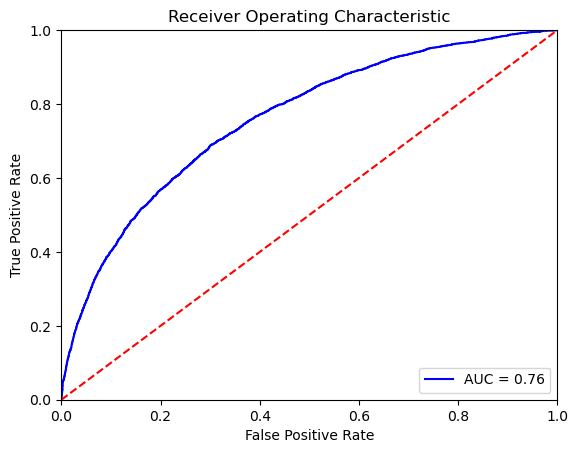

In [54]:
xgb_untuned_gl = train_xgboost(X_train_gl, y_train_gl)
evaluate_model(xgb_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_untuned_gl, "XGBoost", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 81.25%
------------------------------------------------
Confusion Matrix:
       0     1
0  13926   533
1   2912  1007
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89     14459
           1       0.65      0.26      0.37      3919

    accuracy                           0.81     18378
   macro avg       0.74      0.61      0.63     18378
weighted avg       0.79      0.81      0.78     18378



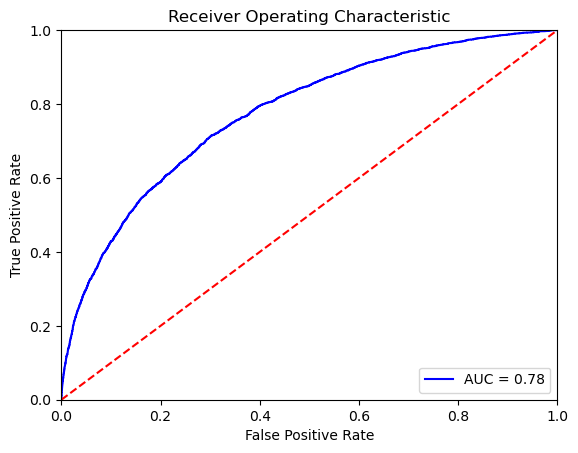

In [55]:
xgb_grid_gl = train_xgboost_tuned_gridsearch(X_train_gl, y_train_gl)
evaluate_model(xgb_grid_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_grid_gl, "XGBoost", "gridsearch", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 80.90%
------------------------------------------------
Confusion Matrix:
       0     1
0  13772   687
1   2824  1095
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89     14459
           1       0.61      0.28      0.38      3919

    accuracy                           0.81     18378
   macro avg       0.72      0.62      0.64     18378
weighted avg       0.78      0.81      0.78     18378



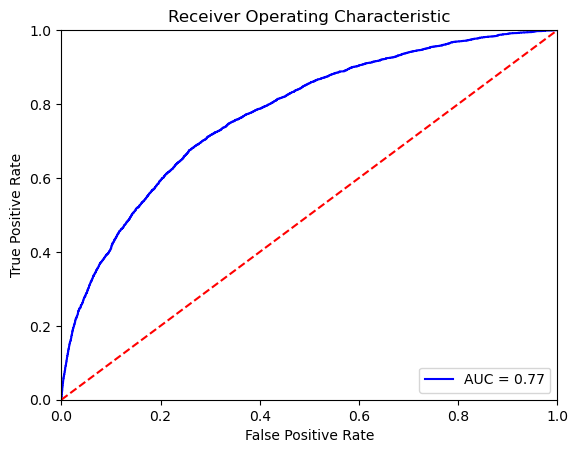

In [56]:
xgb_rand_gl = train_xgboost_tuned_randsearch(X_train_gl, y_train_gl)
evaluate_model(xgb_rand_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_rand_gl, "XGBoost", "randsearch", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

C:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [16:43:07] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "boost" } are not used.

  warnings.warn(smsg, UserWarning)


model accuracy for classification is = 79.31%
------------------------------------------------
Confusion Matrix:
       0     1
0  13340  1119
1   2684  1235
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.88     14459
           1       0.52      0.32      0.39      3919

    accuracy                           0.79     18378
   macro avg       0.68      0.62      0.63     18378
weighted avg       0.77      0.79      0.77     18378



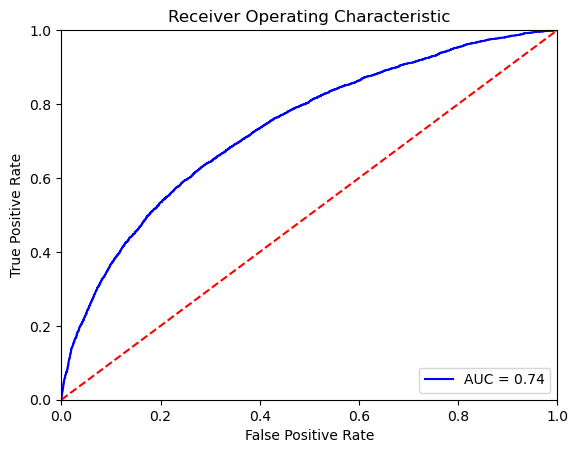

In [57]:
xgb_optuna_gl = train_xgboost_tuned_optuna(X_train_gl, y_train_gl)
evaluate_model(xgb_optuna_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_optuna_gl, "XGBoost", "optuna", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

0:	learn: 0.6555567	total: 25.9ms	remaining: 2.56s
1:	learn: 0.6219014	total: 51ms	remaining: 2.5s
2:	learn: 0.5951343	total: 75.5ms	remaining: 2.44s
3:	learn: 0.5731545	total: 102ms	remaining: 2.44s
4:	learn: 0.5545928	total: 127ms	remaining: 2.41s
5:	learn: 0.5409164	total: 152ms	remaining: 2.38s
6:	learn: 0.5294704	total: 177ms	remaining: 2.35s
7:	learn: 0.5203669	total: 203ms	remaining: 2.34s
8:	learn: 0.5126102	total: 228ms	remaining: 2.31s
9:	learn: 0.5057233	total: 253ms	remaining: 2.28s
10:	learn: 0.5006708	total: 278ms	remaining: 2.25s
11:	learn: 0.4960348	total: 303ms	remaining: 2.22s
12:	learn: 0.4920602	total: 328ms	remaining: 2.2s
13:	learn: 0.4881078	total: 353ms	remaining: 2.17s
14:	learn: 0.4850348	total: 377ms	remaining: 2.14s
15:	learn: 0.4825068	total: 401ms	remaining: 2.11s
16:	learn: 0.4801479	total: 427ms	remaining: 2.08s
17:	learn: 0.4781515	total: 452ms	remaining: 2.06s
18:	learn: 0.4763184	total: 476ms	remaining: 2.03s
19:	learn: 0.4746670	total: 501ms	remainin

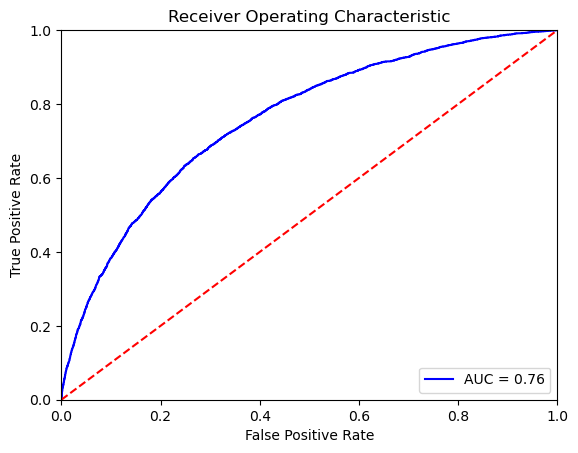

In [58]:
cat_untuned_gl = train_catboost(X_train_gl, y_train_gl)
evaluate_model(cat_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(cat_untuned_gl, "CatBoostClassifier", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

[LightGBM] [Info] Number of positive: 9184, number of negative: 33695
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 42879, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.214184 -> initscore=-1.299887
[LightGBM] [Info] Start training from score -1.299887
model accuracy for classification is = 80.69%
------------------------------------------------
Confusion Matrix:
       0    1
0  13933  526
1   3022  897
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.89     14459
           1       0.63      0.23      0.34      3919

    accuracy                           0.81     18378
   macro avg       0.73      0.60      0.61     18378
weight

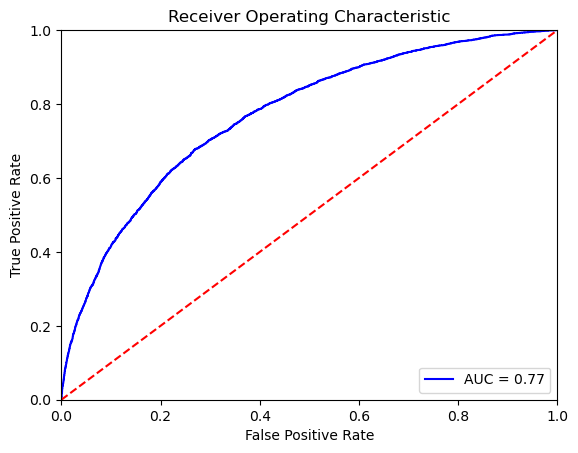

In [59]:
light_untuned_gl = train_lightgbm(X_train_gl, y_train_gl)
evaluate_model(light_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(light_untuned_gl, "LightGBM", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 79.82%
------------------------------------------------
Confusion Matrix:
       0    1
0  13946  513
1   3195  724
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.96      0.88     14459
           1       0.59      0.18      0.28      3919

    accuracy                           0.80     18378
   macro avg       0.70      0.57      0.58     18378
weighted avg       0.76      0.80      0.75     18378



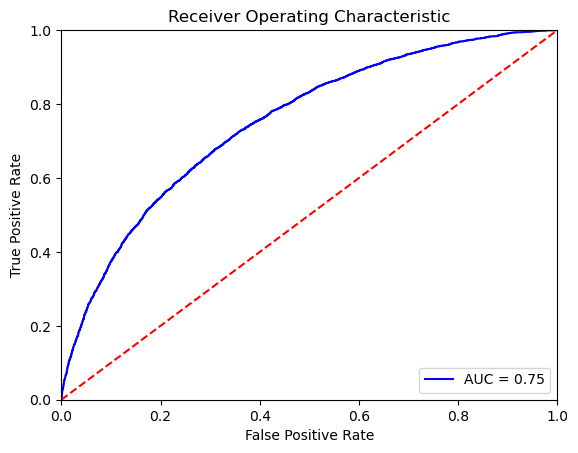

In [60]:
stack_untuned_gl = train_stacking_rf_svm(X_train_gl, y_train_gl)
evaluate_model(stack_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(stack_untuned_gl, "StackingClassifier-RF-SVC", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl,
               y_test_gl)

In [61]:
svc_untuned_gl = train_svc(X_train_gl, y_train_gl)
add_to_eval_df(svc_untuned_gl, "SVC", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Model evaluation

In [62]:
evaluation.sort_values(by=["test_f1"], ascending=False)

,model,tuning,vec_variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
15,BalancedRandomForest,untuned,tf,0.878938,0.638926,0.999782,0.779622,0.740614,0.434467,0.717275,0.541149
3,BalancedRandomForest,untuned,w2v,0.919354,0.726467,1.000000,0.841565,0.717815,0.405094,0.689972,0.510478
27,BalancedRandomForest,untuned,glove,0.915203,0.716381,1.000000,0.834757,0.708619,0.391508,0.661138,0.491791
23,SVC,untuned,tf,0.874671,0.818775,0.532774,0.645515,0.817717,0.616646,0.383771,0.473105
22,StackingClassifier-RF-SVC,untuned,tf,0.984468,0.986298,0.940549,0.962880,0.828055,0.691377,0.349834,0.464588
17,XGBoost,gridsearch,tf,0.859815,0.866991,0.408101,0.554971,0.829089,0.710043,0.335545,0.455727
19,XGBoost,optuna,tf,0.842230,0.781869,0.365309,0.497959,0.826042,0.691005,0.333248,0.449647
21,LightGBM,untuned,tf,0.843653,0.807387,0.354639,0.492813,0.827511,0.711941,0.321000,0.442490
16,XGBoost,untuned,tf,0.848061,0.842619,0.357361,0.501873,0.827729,0.724776,0.309773,0.434036
6,XGBoost,randsearch,w2v,0.935003,0.960945,0.726045,0.827141,0.818533,0.651767,0.319980,0.429232


In [63]:
evaluation.to_csv("eval/evaluation_newdata_train-cleaned.csv")